# STAT 301 Final Report
#### Group 40: Dorothy Ger, Ryan Peng, Sparsh Bajaj, Tony Liang

## 1. Introduction

### 1.1 Background Information on the topic

A motorized vehicle emits around 4.7 tons of carbon dioxide annually (US EPA 2016). To cut down on emissions, bike sharing systems, an innovation from traditional bike rentals, started to emerge as a method of eco-friendly transportation. More than 1000 cities worldwide have implemented a bicycle share program (Lin et al. 2018). From a business perspective, what are factors that effect the number of bicycle rentals became a research area of interest.

### 1.2 The Question

Using the programming language R as a tool for our analysis, we will be attempting to answer the research question: 

   > How are weather patterns statistically significant for predicting number of bike rental counts?


### 1.3 The Dataset

In this report, we will be working on a dataset named “Nike Sharing Dataset” from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), which includes detailed data about rental bikes in Capital bikeshare system. This dataset contains columns with information of: hourly and daily count (`cnt`) of rental bikes, `dates`, `season`, `weather`, etc. We will be looking particularly at which columns can serve as input variables for a predictive model for **daily bike rental counts**. 

The dataset contains the following information: 

`instant`: records the index of the data

`dteday` : is the date in yyyy-mm-dd format

`season` : is the season denoted by numbers (1:winter, 2:spring, 3:summer, 4:fall)

`yr` : is the year denoted by 0 or 1 where 0 means 2011, and 1 means 2012

`mnth` : is the month denoted by numbers 1 through 12

`hr` :  is the hour of the day denoted by numbers 0 through 23

`holiday` : denotes whether the day is holiday or not with 0 meaning no 1 meaning yes.

`weekday` : is the day of the week denoted by numbers 0 through 6

`workingday` : 1 if the day is neither weekend nor holiday, otherwise 0.

`weathersit` :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

`temp` : Normalized temperature in Celsius. Obtained through (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

`atemp`: Normalized feeling temperature in Celsius. Obtained through (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

`hum`: Normalized humidity. The values are divided by 100 (max)

`windspeed`: Normalized wind speed. The values are divided by 67 (max)

`casual`: count of casual users

`registered`: count of registered users

`cnt`: count of total rental bikes including both casual and registered


## 2. Preliminary Results

### 2.0 Load libraries 

In [1]:
# Load required libraries
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(httr)
library(glmnet)
library(leaps)

── Attaching packages ─────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-4



### 2.1 Read data and Wrangling

We will first download a zip that contains both hourly and daily data of the bike sharing dataset, and use the **daily bike data** only as mentioned earlier from our introduction, and load it as dataframe. **Note**: The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [2]:
# Downloads zip to tempfile
BIKE_URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
GET(BIKE_URL, write_disk(tf <- tempfile(fileext = ".zip")))
# Unzip tempfile and disgards the hourly data and use daily only
bike_sharing_day <- read_csv(unz(tf, "day.csv"))
# Unlink/remove the temporary file
unlink(tf)
head(bike_sharing_day)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip]
  Date: 2022-12-08 02:54
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 280 kB
<ON DISK>  C:\Users\chunq\AppData\Local\Temp\RtmpoZiPLl\file1a70e57641e.zipNULL

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


Before removing any columns, we are going to get some summary statistics of all variables to check how is the data distributed.

In [3]:
tab <- bike_sharing_day %>%
    select_if(is.numeric) %>%
    pivot_longer(cols = everything(),
                 names_to = "Variable",
                 values_to = "value") %>%
    group_by(Variable) %>%
    summarize(
        Min = round(min(value), 4),
        `1st Quantile` = round(quantile(value, 0.25), 4),
        Mean = round(mean(value), 4),
        Median = round(median(value), 4),
        `3rt Quantile` = round(quantile(value, 0.75), 4),
        Sd = round(sd(value), 4),
        Max = round(max(value), 4))
t(tab)

Variable,atemp,casual,cnt,holiday,hum,instant,mnth,registered,season,temp,weathersit,weekday,windspeed,workingday,yr
Min,0.0791,2.0000,22.0000,0.0000,0.0000,1.0000,1.0000,20.0000,1.0000,0.0591,1.0000,0.0000,0.0224,0.0000,0.0000
1st Quantile,0.3378,315.5000,3152.0000,0.0000,0.5200,183.5000,4.0000,2497.0000,2.0000,0.3371,1.0000,1.0000,0.1349,0.0000,0.0000
Mean,0.4744,848.1765,4504.3488,0.0287,0.6279,366.0000,6.5198,3656.1724,2.4966,0.4954,1.3953,2.9973,0.1905,0.6840,0.5007
Median,0.4867,713.0000,4548.0000,0.0000,0.6267,366.0000,7.0000,3662.0000,3.0000,0.4983,1.0000,3.0000,0.1810,1.0000,1.0000
3rt Quantile,0.6086,1096.0000,5956.0000,0.0000,0.7302,548.5000,10.0000,4776.5000,3.0000,0.6554,2.0000,5.0000,0.2332,1.0000,1.0000
Sd,0.1630,686.6225,1937.2115,0.1672,0.1424,211.1658,3.4519,1560.2564,1.1108,0.1831,0.5449,2.0048,0.0775,0.4652,0.5003
Max,0.8409,3410.0000,8714.0000,1.0000,0.9725,731.0000,12.0000,6946.0000,4.0000,0.8617,3.0000,6.0000,0.5075,1.0000,1.0000


We noticed `temp`, `atemp`, `hum`, `windspeed` are all "normalized" variables given from the originial dataset description according to some transformations. Moreover, we have some time variables like: `weekday`, `mnth`, `dteday`, whereas we are going to discard these for easiness of modelling and not consider it at all when selecting variables. Also, according to the original dataset, we know that `cnt` = `casual` + `registered`, hence this could likely cause collinearity problem later, and we would only focus on `cnt` as a response variable. Also, similar variables like holiday, workingday might have similar issue, hence we would keep one of the two.

In [4]:
# Wrangling data
# Selecting relevant/meaningful columns
# Transform categorical variables to factors
bike_wrangled <- bike_sharing_day %>%
                 select(yr, workingday:windspeed, cnt) %>%
                 mutate(across(yr:weathersit, as.factor))
head(bike_wrangled, 6)

yr,workingday,weathersit,temp,atemp,hum,windspeed,cnt
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,2,0.344167,0.363625,0.805833,0.1604460,985
0,0,2,0.363478,0.353739,0.696087,0.2485390,801
0,1,1,0.196364,0.189405,0.437273,0.2483090,1349
0,1,1,0.200000,0.212122,0.590435,0.1602960,1562
0,1,1,0.226957,0.229270,0.436957,0.1869000,1600
0,1,1,0.204348,0.233209,0.518261,0.0895652,1606


Next, we are also checking if there exist further collinearity problem in the remaining numeric variables by plotting a heat map of these predictors.

In [5]:
# This cell is to control plot size
options(repr.plot.width = 12, repr.plot.height = 12)

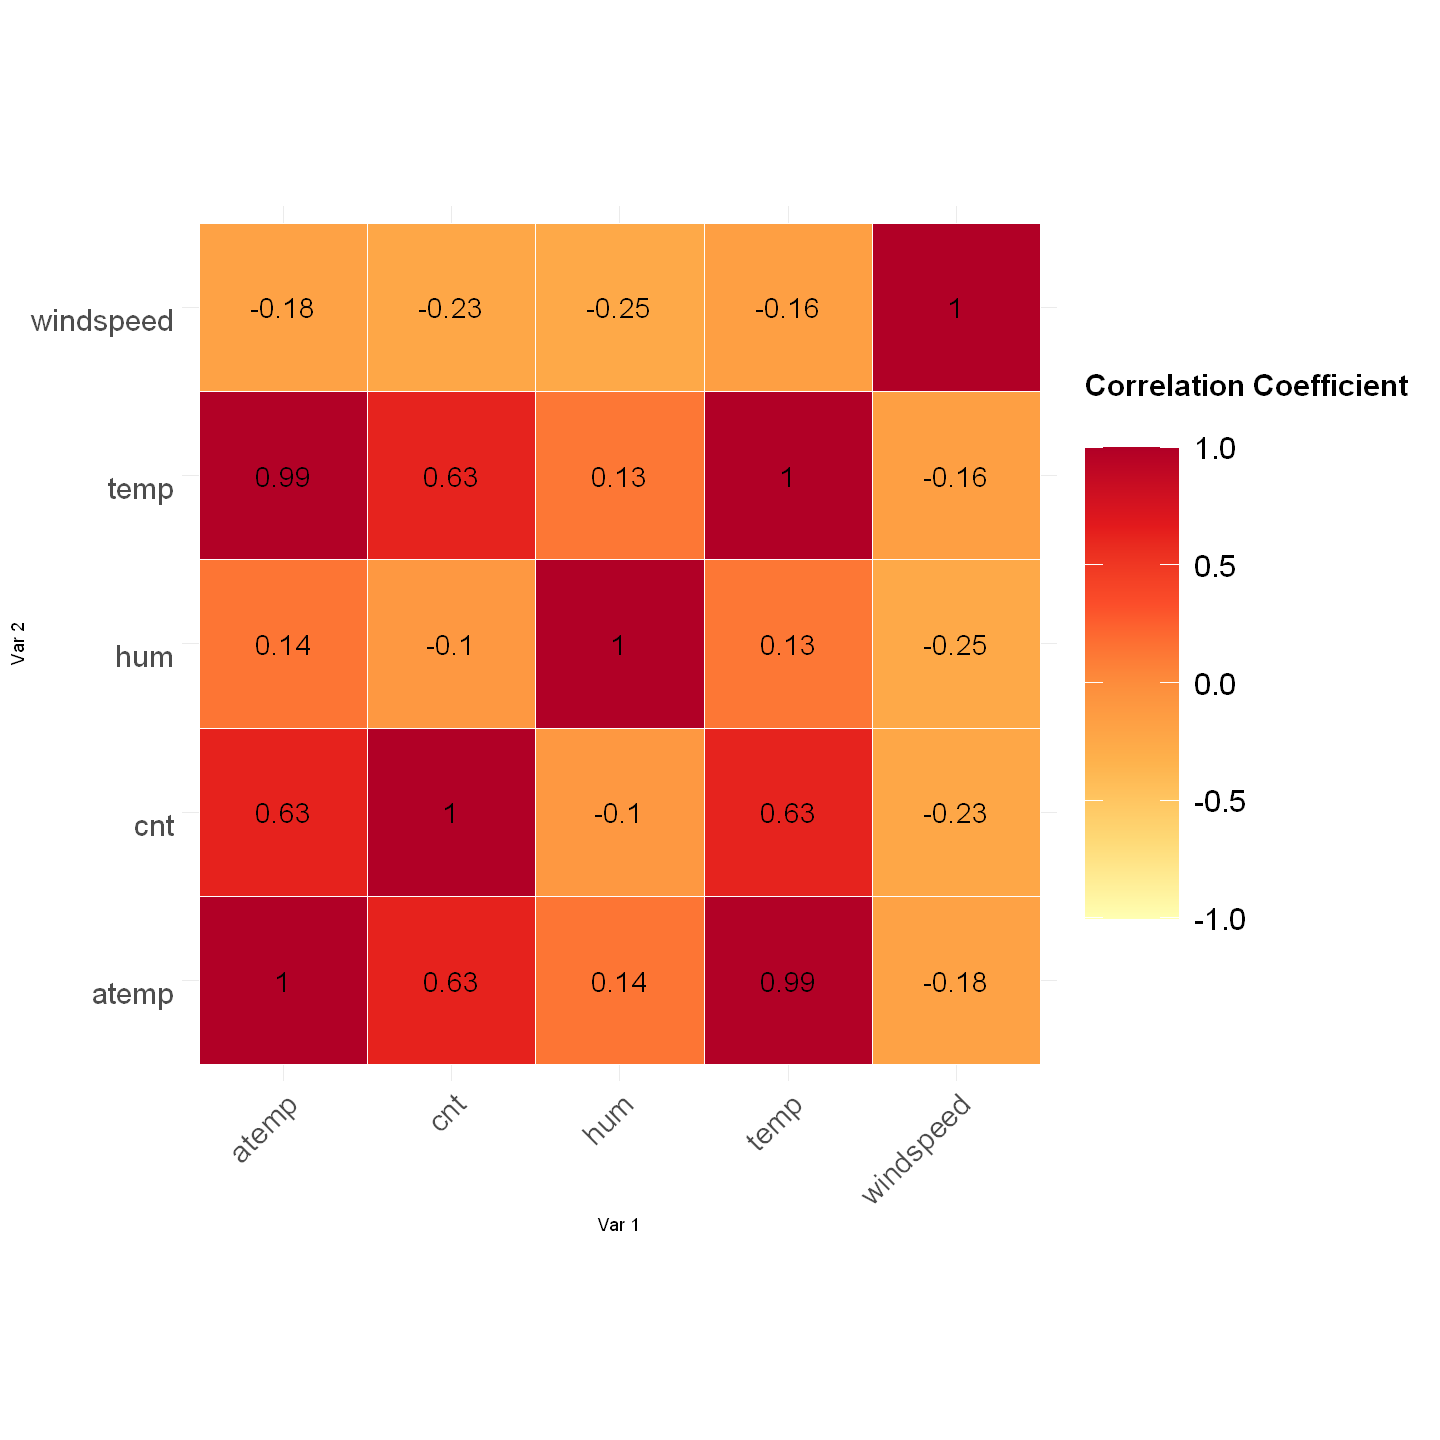

In [6]:
# Correlation marix of numeric predictors
corr_mat <- cor(bike_wrangled %>% select_if(is.numeric)) %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

# Plot heat map of correlation matrix
plot_corr_matrix <- corr_mat %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "Var 1", y = "Var 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix

We notice `temp` and `atemp` are highly correlated, this indicates that there might exist collinearity between the two variables, which will be handled later.

Now we will visualize the distribution of our response variable, `cnt`, in a histogram first. We can see that the distibution is roughly follows a normal distribution but also have a chance in being multimodal; with a mean of approximately 4500.

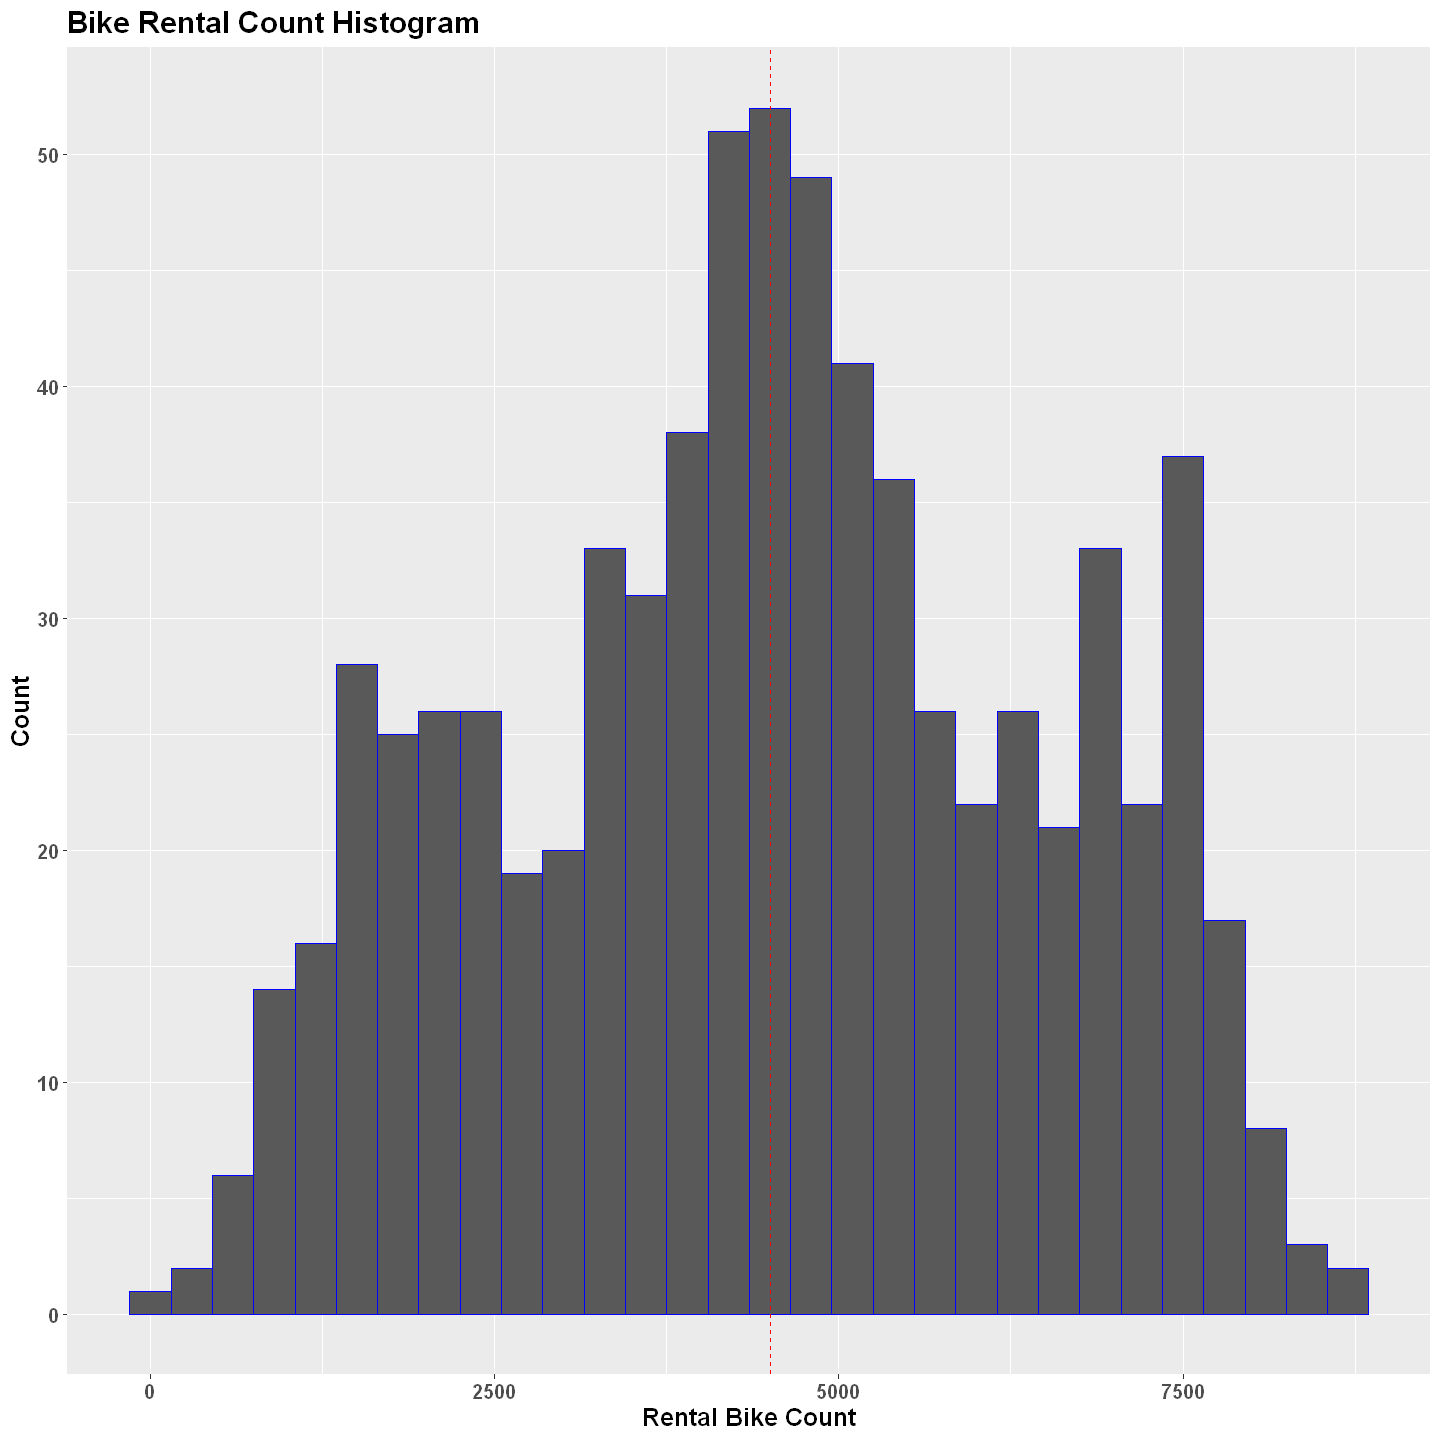

In [7]:
bike_wrangled %>% ggplot(aes(x = cnt)) + 
    geom_histogram(binwidth = 300, alpha = 2,color = "blue") +
    geom_vline(aes(xintercept=mean(cnt)), color="red",
             linetype="dashed")+
    labs(title="Bike Rental Count Histogram",x="Rental Bike Count", 
         y = "Count")+
    theme(text=element_text(size=15, face = "bold"))

By creating a Q-Q plot, we can see that some data points deviate away from the 45-degree red line and is therefore a bit heavy-tailed.

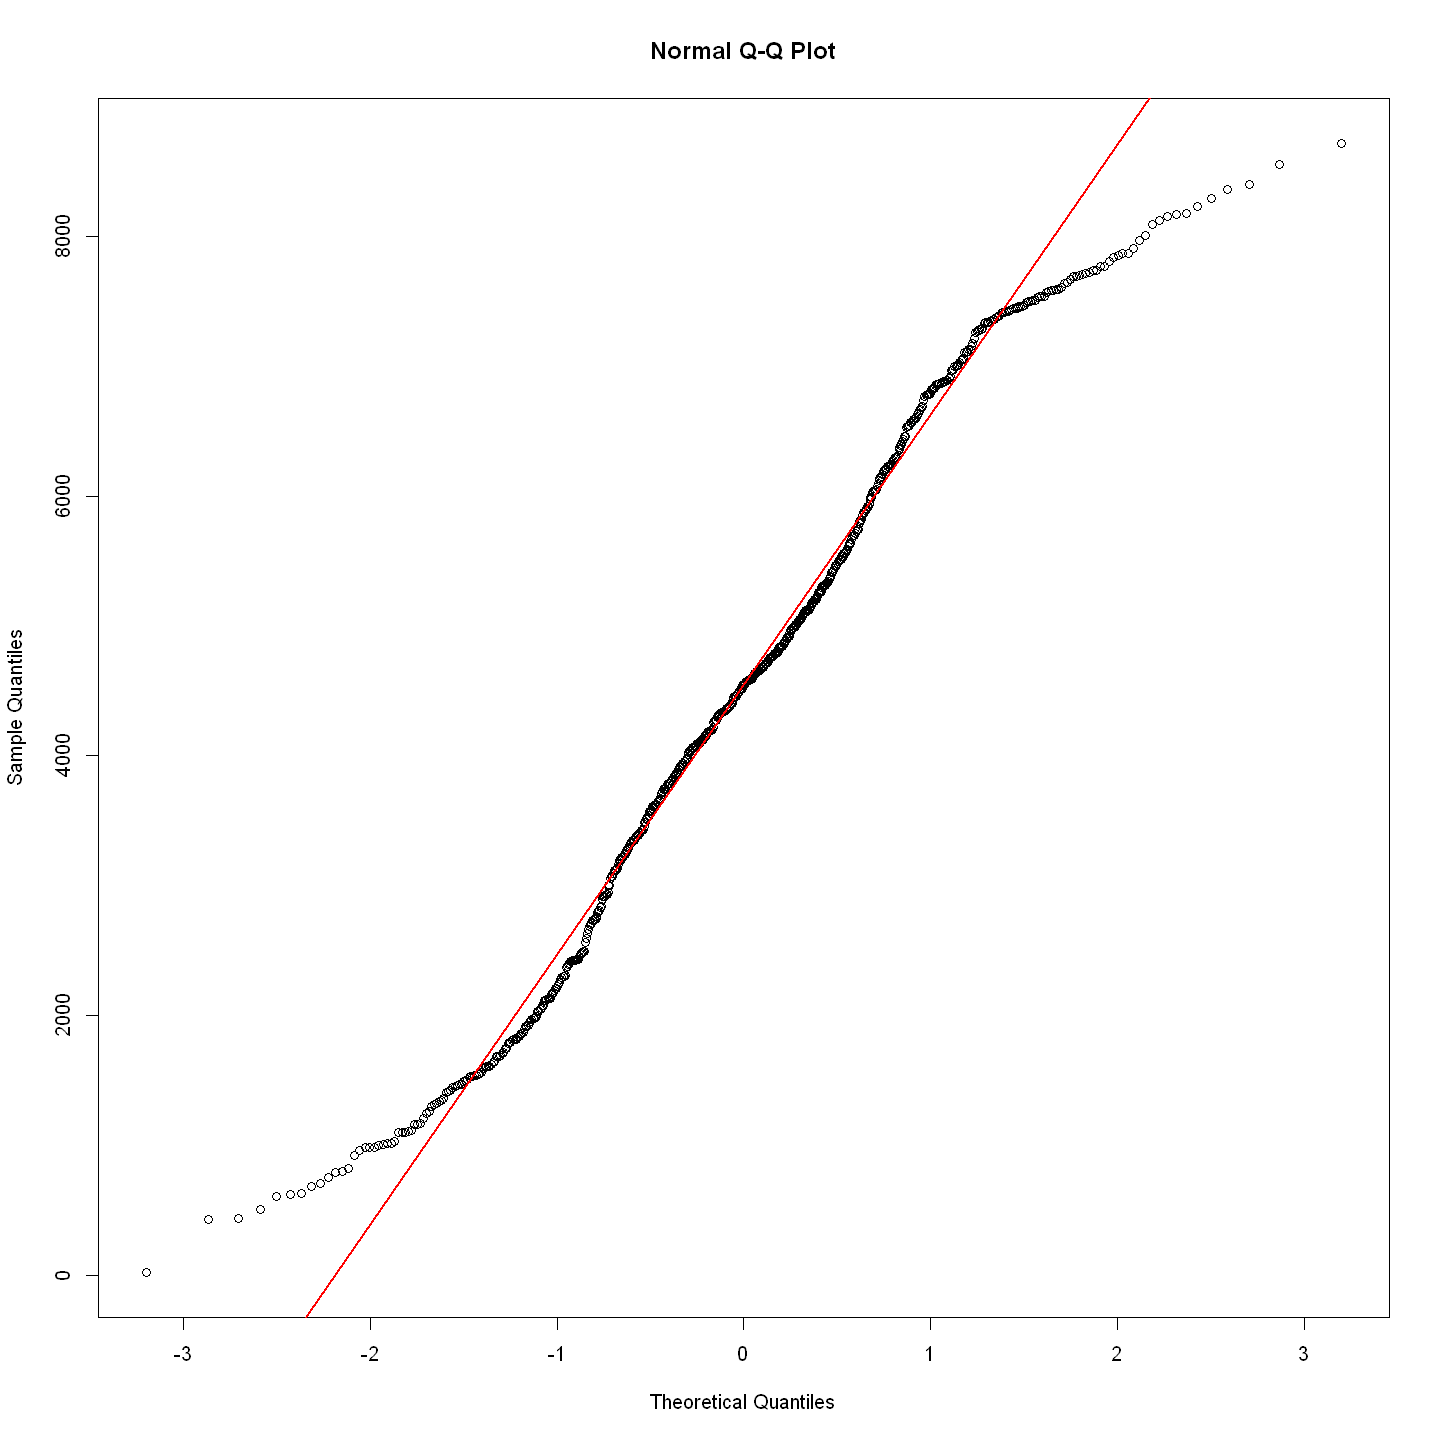

In [8]:
qqnorm(bike_wrangled$cnt)
qqline(bike_wrangled$cnt, col = "red", lwd = 2)

## 3. Methods

### 3.1 What methods do you plan on using?

For our proposal, we plan to predict the count of bikes using the variable `cnt` by using following predictors: `temp`, `hum`, `windspeed`, `yr`, `workingday`, `weathersit`.  We plan to make this prediction using **Poisson Regression** as we believe it can be effectively used for modeling count data (count of bikes, which is discrete). If we assume our different independent predictor variables $x_1$, $x_2$, $x_3$, ..., $x_n$ etc and our response variable (`cnt`) to be $Y$, then our model can be described as shown below: 
<br>
 $log (\lambda: \mathbb{E}(Y|x)) = \beta_{0} + \beta_{1} x_1 + \beta_{2}x_2 + ... + \beta_{n} x_n$.
 
 Where $\lambda$ is the mean of our observed values $Y_i$, and also its variance, assuming $Y_i \sim \text{Poisson, where}$ $\lambda = \lambda_i $ 
 
 
 

### 3.2 Analysis

We are now doing further analysis on our dataset as proposed earlier. Recall the question we are trying to answer is:
> **How are weather patterns statistically significant for predicting number of bike rental counts?**

In order to answer above question, we have a outline of steps to be carried as following:
1) Check if our data matches assumption for Poisson Regression.
 2) Split data to train ($70\%$ of data) and test ($30\%$ of data).
     - The proportion of data $70\%$ and $30\%$ are picked randomly
 
 2) ~~Use the train data to train a baseline model and use various regularization methods **(LASSO/Ridge)** to compare models.~~
 2) Use the train data perform possible feature selection to increase our prediction performance.
 3) Carry **cross-validation (CV)** to tune hyperparameters in our regularization methods for optimal prediction performance.
 4) After retrieving the "optimal" model we could have, use the test set to evaluate its performance on future "unseen" data.
 5) Gather results and wrap it to figures/tables.
 
**Note**: we have done some checks in previous proposal stage like checking for collinearity, normality, excluding variable and many others, hence those assumptions implies and will not be mentioned any more in the final report.

In [9]:
# remove the atemp column due to collinearity
bike_wrangled <-  bike_wrangled %>% select(-atemp)
head(bike_wrangled)

yr,workingday,weathersit,temp,hum,windspeed,cnt
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,2,0.344167,0.805833,0.1604460,985
0,0,2,0.363478,0.696087,0.2485390,801
0,1,1,0.196364,0.437273,0.2483090,1349
0,1,1,0.200000,0.590435,0.1602960,1562
0,1,1,0.226957,0.436957,0.1869000,1600
0,1,1,0.204348,0.518261,0.0895652,1606


Note that we have several factor encoded categorical variables, and others standardized predictors (mentioned in the introduction) with our response being on a very big scale, hence we might need to account for this when selecting features (i.e. standardizing these counts or force it to a smaller range of values, as that's what Poisson Regression meant to do). As mentioned above, our response variable `cnt` is a huge scale compared to other variables

In [10]:
# Set seed to reprodoce results
set.seed(20221210)
sample_n(size = 30, bike_wrangled)$cnt

[1] 4790 2302 7572 6779 7129 4169 3214 4717 1495 7058 4189 3982 1360 4458 3641
[16] 3389 1096 3163 4634 7415 6565 1815 4672 2132 2703 6664 2162 2425 6192 5463

For simplicity we take 30 random samples of this wrangled bike data and see what ranges the `cnt` goes. As noted above, we could `cnt` are mostly above 1000 and could go upto 7000, hence for simplicity we our going to divided all of our `cnt`  by 1000, and round it to neareast integer. Below is a summary table after applying such transformation and counting numbers of these same `cnt_scaled` among observations.

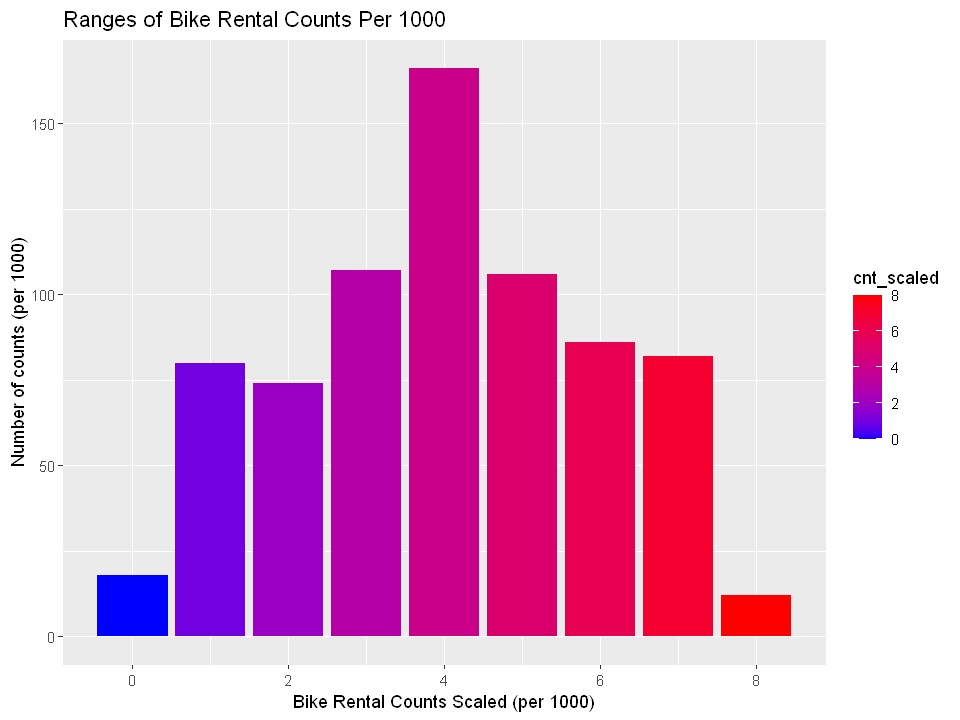

In [23]:
# change size
options(repr.plot.width = 8, repr.plot.height = 6)
# visualizing the counts per 1000 distritbution, 0 means less than 1000
bike_wrangled %>% 
    summarize(cnt_scaled = as.integer(cnt/ 1000)) %>% 
    group_by(cnt_scaled) %>%
    summarize(n_cnts = n()) %>%
    ggplot(aes(x = cnt_scaled, y = n_cnts, fill = cnt_scaled)) +
    geom_col() +
    scale_fill_continuous(low="blue", high="red") +
    labs(x = "Bike Rental Counts Scaled (per 1000)",
         y = "Number of counts (per 1000)") +
    ggtitle("Ranges of Bike Rental Counts Per 1000")


We could see in our data, that most daily bike rental counts are around 4000, since these are the ones that occured the most from table above. Now we will just do the transformation then split data to train and test portion.

In [12]:
# setting a seed to reproduce
set.seed(20221210)
# 70% of the sample size
bike_scaled <- bike_wrangled %>% mutate(cnt = as.integer(cnt/1000))
n <- nrow(bike_scaled)
size <- floor(0.70 * n)
# index of these samples
train_ind <- sample(seq_len(n), size = size)
# split the data into train and test portion
# train data
bike_train <- bike_scaled[train_ind,]
# test data
bike_test <- bike_scaled[-train_ind,]

# view first 6 train data
head(bike_train)

yr,workingday,weathersit,temp,hum,windspeed,cnt
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
0,1,2,0.728333,0.703333,0.2388040,4
0,1,1,0.299130,0.503913,0.2939610,2
1,1,2,0.657500,0.793750,0.0665458,7
1,1,1,0.715833,0.504167,0.3003830,6
1,0,1,0.620833,0.530417,0.2543670,7
1,1,1,0.348333,0.531250,0.1816000,4


### 3.3 Feature Selection

After split the data above, now we could mess a round a bit with our data (which we means the train data). Although the wrangled data already consists of small set of predictors, but we would like to apply some methods that could possibly select useful variables for a predictive model. Given we have some categorical variables, then doing group LASSO or even sparse-group LASSO is not quite feasible for this project, therefore we have other stepwise algorithms left to use. Next, we will apply both forward and backward selection algortihm to find possible subsets of the full model that achieves highest test score (in this case, we use deviance since Poisson Regression do not belongs to the gaussian family). <--- **Proofread and check**

#### LASSO

We only care about predictive performance of the optimal model, hence we would go straight using penalized regression of LASSO method of L1-norm penalty. Moreover, by its nature, we could hopefully get a subset of variables selected as well from the set of all predictors. In addition, we would carry a 10 fold CV as well to tune hyperparameter $\lambda$ and calculate its beta coefficients for the Poisson Regression.

**Note**: Poisson Regression do not belongs to the gaussian family, hence we could not use any of MSE measurements to estimate the loss, and will then use deviance instead as the measurement.

In [13]:
# retrieve X and y matrix to ease our calculations
# X matrix
X_train <- model.matrix(cnt ~ . , bike_train)[,-1]
#X_train <- bike_train %>% select (-cnt)
#X_train <- apply(X, 2, as.numeric)
# Y response
Y_train <- bike_train$cnt

# Fit a CV of LASSO Poisson Regression 
# to find optimal lambda that give us best predictive score
cv_lasso <- cv.glmnet(
    x = X_train,
    y = Y_train,
    family = "poisson",
    nfolds = 10,
    alpha = 1,
    type.measure = "mse"
    )

We could then visualize these CV glmnet of our LASSO Poisson Regression to see how many non-zero predictors exists at our lambda.1se, that is given us low risk estimate while being 1 Standard Error within the the lambda that gives the mininum risk estimate. <--- **Proofread and check?**

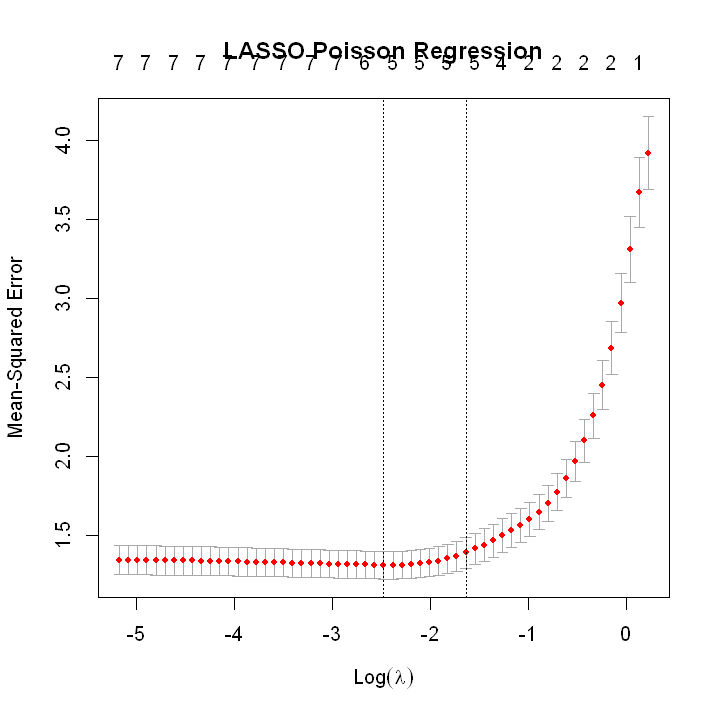

In [14]:
# change size of plot
options(repr.plot.width = 6, repr.plot.height = 6)
# plot the cv glmnet with deviance vs log lambda
plot(cv_lasso, main = "LASSO Poisson Regression")

By looking at the `lambda.1se` of the plot above (which is the second vertical line near the right), the `cv.glmnet` is telling us that there still exists 5 non-zero beta estimates for our Poisson Regression with LASSO penalty. Hence, this suggests that we could use less variables for our final model to make predictions with. Now, let's see what are those selected covariates:

In [15]:
# First retrieve value of lambda 1se
# then fit a poisson glmnet with that lambda
# lambda of 1se
lam_1se <- round(cv_lasso$lambda.1se, 2)

# Fitting the glmnet with optimal lambda
optimal_pois <- glmnet(
    x = X_train,
    y = Y_train,
    family = "poisson",
    alpha = 1,
    lambda = lam_1se,
    type.measure = "mse"
    )
# selected covariates by LASSO
coefs <- coef(cv_lasso, s = "lambda.1se")
data.frame(covariates = coefs@Dimnames[[1]][which(coefs != 0)][-1],
           coefficients = coefs[which(coefs != 0)][-1]) %>%
    mutate(coefficients = round(coefficients, 2))

covariates,coefficients
<chr>,<dbl>
yr1,0.44
weathersit2,-0.02
weathersit3,-0.22
temp,1.36
windspeed,-0.34


We could see that applying regularization method like LASSO, we have constrained and selected less variables for our final model, with `yr`, `weathersit`, `temp` and `windspeed` being selected, whereas originally we had 7 predictors and now reduced to 5, which means the model is less complex and is more generalized upon predicting unseen data. Now we could finally use this optimal model to predict on our unseen data (the test set).

In [16]:
# separate X and y for test data
# "new X" from the test data
X_test <- model.matrix(cnt~., bike_test)[,-1]
# "new Y" to evaluate our performance of the optimal model
Y_test <- bike_test$cnt

# Predict on the test data
predictions <- predict(optimal_pois, newx = X_test, type = "response") %>%
        `rownames<-`(NULL) %>%
        as.data.frame() %>%
        rename(predictions = s0) %>%
        mutate(predictions = round(predictions, 0))

# Append predicions with actual
set.seed(20221210)
responses <- cbind(actuals = bike_test$cnt, preds = predictions)
tail(sample_n(size = 6, responses))


,actuals,predictions
,<int>,<dbl>
1,5,6
2,1,2
3,2,3
4,4,4
5,6,7
6,6,6


We combined the actual values of scaled `cnt` and their predictions based on the model, out of 6 random samples taken out, 2 of them correctly predicted the count, whereas others had 1 difference (then in terms of the original scale, we always predicted 1000 more/less of the actual count). Therefore we are going to calculate the rmse of this to evaluate how good the model performed to estimate how good it could be in predicting future unseen data. 

In [17]:
# calculate the RMSE
pois_rmse <- responses %>% summarize(RMSE = sqrt(mean((actuals - predictions)^2))) %>% round(2)
pois_rmse

RMSE
<dbl>
1.17


After calculating the RMSE of our optimal model with test data, we can see on average the difference between our predictions is $1.17$, or better than said is $1$ unit of this transformed scale of per $1000$ daily bike rental counts. Since that is how we transformed our response variable `cnt` to this scaled version by dividing $1000$, then rounded to nearest whole integer.

### TRASH?

Now we are training a Linear Regression (LR) model, and a Poisson Regression (PR) model with all variables to compare their in-sample error.

In [18]:
# calculate the deviance
# deviance <- 2 * sum(dpois(Y_test, preds, log = TRUE))
# deviance

In [19]:
# set.seed(1010)
# n <- 100
# p <- 200
# X <- matrix(data = rnorm(n*p, mean = 0, sd = 1), nrow = n, ncol = p)
# eps <- rnorm(n, mean = 0, sd = 1)
# beta_star <- c(rep(5, 5), c(5, -5, 2, 0, 0), 
#                rep(-5, 5), c(2, -3, 8, 0, 0), rep(0, (p - 20)))
# y <- X %*% beta_star + eps
# groups <- rep(1:(p / 5), each = 5)
# fit1 <- sparsegl(X, y, group = groups)
# plot(fit1, y_axis = "coef", x_axis = "penalty", add_legend = FALSE)

In [20]:
# # Get design matrix to ease our calculations
# # remove the response variable to have design matrix
# #X <- bike_train %>% select(-cnt) %>% as.matrix()
# # get the response to ease our calculations
# #y <- bike_train$cnt
                                               
# # Forward selection 
# forward <- regsubsets(cnt ~ . , data = bike_train,  method = "forward",
#                      nbest = 2)
# # Backward selection
# #tidy(forward) %>% arrange(desc(adj.r.squared))

#### LASSO

In [21]:
# set.seed(20221210)
# # Separating X and y
# X <- model.matrix(pois, bike_train)[, -1]
# Y <- as.matrix(bike_train$cnt, ncol = 1)
# # Fitting a 10 fold cv glmnet with default lambda values
# cv_lasso <- cv.glmnet(
#     x = X,
#     y = Y,
#     alpha = 1,
#     family = "poisson",
#     type.measure = "mse",
#     nfolds = 10
# )

In [22]:
# # function to calculate rmse
# rmse <- function(pred, truth) {
#     sqrt(mean(sum((pred - truth)^2)))
# }
# # fit a lR model
# slr <- lm(cnt ~ ., data = bike_train)
# # fit a poisson model
# pois <- glm(formula = cnt ~ . , data = bike_train, family = "poisson")

# # merge results and display in table
# baselines <- data.frame(truth = bike_train$cnt, lr_pred = predict(slr),
#                        poisson_pred = predict(pois, type = "response")) %>%
#              mutate_if(is.numeric, round, 0)
# head(baselines)

# # comparison of rmses
# rmse_comp <- baselines %>%
#              summarize(LR = rmse(pred = lr_pred, truth = truth),
#                        Poisson = rmse(pred = poisson_pred, truth = truth)) %>%
#              pivot_longer(everything(),
#                           names_to = "Model",
#                           values_to = "RMSE") %>%
#              mutate_if(is.numeric, round, 0)

# rmse_comp

**Add some explanations above?**

In [23]:
# # Plot the lasso mse (y-axis) vs log_lambda(x-axis) 
# plot(cv_lasso)

In [24]:
# # fit the 1se lasso
# bike_lasso_1se <- glmnet(
#     x = X,
#     y = Y,
#     alpha = 1,
#     family = "poisson",
#     lambda = round(cv_lasso$lambda.1se, 4)
# )
# # get the coefficients
# lasso_coef <- coef(bike_lasso_1se)
# data.frame(covariates = lasso_coef@Dimnames[[1]][which(lasso_coef != 0)],
#           beta = lasso_coef@x[which(lasso_coef != 0)])[-1,] %>%
#     drop_na()

In [25]:
# poisson_lasso <- glm(formula = cnt ~ weathersit + temp + yr, data = bike_test,
#     family ="poisson"
#     )

# rmse(predict(poisson_lasso, type = "response", newdata = bike_test), bike_test$cnt)

In [26]:
# rmse(predict(slr, newdata = bike_test), bike_test$cnt)

In [27]:
# Separate X and y of test data
#model_matrix_X_test <- model.matrix(object = pois, data = bike_test)[,-1]
# Selected X from lasso
#X_lasso <- model_matrix_X_test[, !colnames(model_matrix_X_test) %in% c("workingday1", "hum", "windspeed")]
# fit the glmnet
#test_lasso <- glmnet(
#    x = X_lasso,
#    y = Y,
    

**Add explanations here as well ^**

### 3.4 Results

## 4. References

US EPA, O. (2016). *Greenhouse Gas Emissions from a Typical Passenger Vehicle*. US EPA. https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle-0

Lin, L., He, Z., & Peeta, S. (2018). *Predicting station-level hourly demand in a large-scale bike-sharing network: A graph convolutional neural network approach* Transportation Research. Part C, Emerging Technologies, 97, 258-276. https://doi.org/10.1016/j.trc.2018.10.011

Bike Sharing Dataset Data Set . UCI Machine Learning Repository: Bike sharing dataset data set. (n.d.). Retrieved October 31, 2022, from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Zhang, S., He, K., Dong, S., & Zhou, J. (2016, February 15). Modeling the distribution characteristics of urban public bicycle rental duration. Discrete Dynamics in Nature and Society. Retrieved October 26, 2022, from https://www.hindawi.com/journals/ddns/2016/8947525/

Yang, L., Shen, Q., & Li, Z. (2016, July 19). Comparing travel mode and trip chain choices between holidays and weekdays. Transportation Research Part A: Policy and Practice. Retrieved October 26, 2022, from https://www.sciencedirect.com/science/article/pii/S0965856416301781
